In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw12.ipynb")

<img style="display: block; margin-left: auto; margin-right: auto" src="./ccsf-logo.png" width="250rem;" alt="The CCSF black and white logo">

# Homework 12: Error Analysis

## References

* [Inference for Regression](https://inferentialthinking.com/chapters/16/Inference_for_Regression.html)
* [`datascience` Documentation](https://datascience.readthedocs.io/)
* [Python Quick Reference](https://ccsf-math-108.github.io/materials-sp24/resources/quick-reference.html)

## Assignment Reminders

- Make sure to run the code cell at the top of this notebook that starts with `# Initialize Otter` to load the auto-grader.
- For all tasks indicated with a 🔎 that you must write explanations and sentences for, provide your answer in the designated space.
- Throughout this assignment and all future ones, please be sure to not re-assign variables throughout the notebook! _For example, if you use `max_temperature` in your answer to one question, do not reassign it later on. Otherwise, you will fail tests that you thought you were passing previously!_
- We encourage you to discuss this assignment with others but make sure to write and submit your own code. Refer to the syllabus to learn more about how to learn cooperatively.
- Unless you are asked otherwise, use the non-interactive visualizations when asked to produce a visualization for a task.
- View the related <a href="https://ccsf.instructure.com" target="_blank">Canvas</a> Assignment page for additional details.

Run the following code cell to import the tools for this assignment.

In [2]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter('ignore')

## Regression Inference

Previously, you've used confidence intervals to quantify uncertainty about estimates. You can also run hypothesis tests using a confidence interval under the following procedure:

1. Define a null and alternative hypothesis (they must be of the form "The parameter is X" and "The parameter is not X").
2. Choose a p-value cutoff, and call it $q$.
3. Construct a $(100-q)\%$ interval using bootstrap sampling (for example, if your p-value cutoff is 0.01, or 1%, then construct a 99% confidence interval).
4. Using the confidence interval, determine if your data are more consistent with your null or alternative hypothesis:
   * If the null hypothesis parameter X is in your confidence interval, the data are more consistent with the null hypothesis.
   * If the null hypothesis parameter X is *not* in your confidence interval, the data are more consistent with the alternative hypothesis.

More recently, we've discussed the use of linear regression to make predictions based on correlated variables. For example, we can predict the height of children based on the heights of their parents.

We can combine these two topics to make powerful statements about our population by using the following techniques:

- Bootstrapped interval for the true slope
- Bootstrapped prediction interval for y (given a particular value of x)

This homework explores these two methods.

## The Data

The [Snowy Plover](https://www.audubon.org/field-guide/bird/snowy-plover) is a tiny bird that lives on the coast in parts of California and elsewhere. It is so small that it is vulnerable to many predators, including people and dogs that don't look where they are stepping when they go to the beach. It is considered endangered in many parts of the U.S.

The data are about the eggs and newly-hatched chicks of the Snowy Plover. Here's a picture of [a parent bird incubating its eggs](http://cescos.fau.edu/jay/eps/articles/snowyplover.html).

<img src="plover_and_eggs.jpeg" alt="Plover and Eggs">

The data were collected at the Point Reyes National Seashore by a former [student at Berkeley](https://openlibrary.org/books/OL2038693M/BLSS_the_Berkeley_interactive_statistical_system). The goal was to see how the size of an egg could be used to predict the weight of the resulting chick. The bigger the newly-hatched chick, the more likely it is to survive.

<img src="plover_and_chick.jpeg" alt="Plover and Chick">

Each row of the table below corresponds to one Snowy Plover egg and the resulting chick. Note how tiny the bird is:

- `Egg Length` and `Egg Breadth` (widest diameter) are measured in millimeters
- `Egg Weight` and `Bird Weight` are measured in grams; for comparison, a standard paper clip weighs about one gram

In [3]:
birds = Table.read_table('snowy_plover.csv')
birds

Egg Length,Egg Breadth,Egg Weight,Bird Weight
28.8,21.84,7.4,5.2
29.04,22.45,7.7,5.4
29.36,22.48,7.9,5.6
30.1,21.71,7.5,5.3
30.17,22.75,8.3,5.9
30.34,22.84,8.5,5.8
30.36,22.5,8.2,5.8
30.46,22.72,8.3,6
30.54,23.31,9,6.1
30.62,22.94,8.5,6.2


In this investigation, we will be using the egg weight to predict bird weight. Run the cell below to create a scatter plot of the egg weights and bird weights, along with their line of best fit.

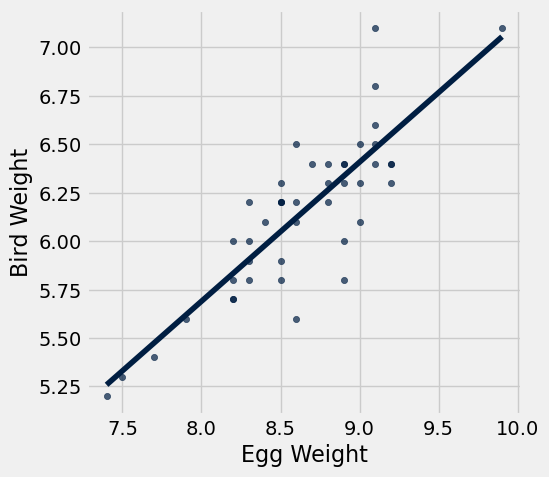

In [4]:
# Just run this cell and examine the scatter plot.
birds.scatter('Egg Weight', "Bird Weight", fit_line=True)

## Residual Plot

It seems like a linear model might be appropriate to apply to this situation, but you should check the residual plot before moving forward. You'll likely find the following functions useful.

In [5]:
def standard_units(data):
    return (data - np.mean(data)) / np.std(data)

def correlation(tbl, x_col, y_col):
    return np.mean(standard_units(tbl.column(x_col)) * standard_units(tbl.column(y_col)))

#### Task 01 📍

Create a function called `fit_line`.  It should take a table (e.g. `birds`) and the column names associated with *x* and *y* as its arguments and return an *array* containing the slope and intercept of the regression line (in that order) that predicts the *y* column in the table using the *x* column.

_Points:_ 3

In [8]:
def fit_line(tbl, x_col, y_col):
    r = correlation(tbl, x_col, y_col)
    
    x_mean = np.mean(tbl.column(x_col))
    y_mean = np.mean(tbl.column(y_col))
    x_std = np.std(tbl.column(x_col))
    y_std = np.std(tbl.column(y_col))
    
    slope = r * (y_std / x_std)
    intercept = y_mean - slope * x_mean
    
    return np.array([slope, intercept])

fit_line(birds, "Egg Weight", "Bird Weight")

array([ 0.71851534, -0.05827226])

In [9]:
grader.check("task_01")

task_01 results: All test cases passed!
task_01 - 1 message: ✅ Your fit_line function produces an array.
task_01 - 2 message: ✅ The array from your fit_line function contains 2 items.
task_01 - 3 message: ✅ Your fit_line function produced the correct two values for our test data.

Now, run the following cell to plot the line produced by calling `fit_line` on the `birds` table.

**Note:** You are not responsible for the code in the cell below, but make sure that your `fit_line` function generates a reasonable line for the data. Compare the line with the line produced in the scatter plot above with the `fit_line=True` parameter.

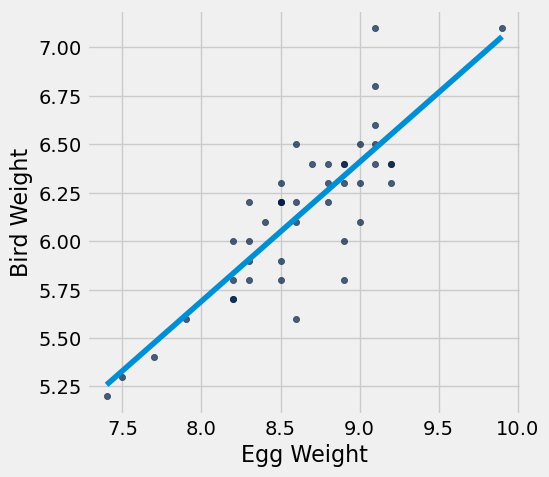

In [10]:
# Just run this cell
slope, intercept = fit_line(birds, "Egg Weight", "Bird Weight")
birds.scatter("Egg Weight", "Bird Weight")
plt.plot([min(birds.column("Egg Weight")), 
          max(birds.column("Egg Weight"))], 
         [slope*min(birds.column("Egg Weight"))+intercept, 
          slope*max(birds.column("Egg Weight"))+intercept])
plt.show()

### Task 02 📍

With a linear regression model, update the `birds` table with a column of predicted birth weights using the regression line and the associated residuals.

1. Create an array called `predicted_bird_weights` that contains the predicted bird weights from the regression line.
2. Create an array called `residuals` that contains the residuals associated with those predictions.
3. Update the `birds` table to include columns `'Predicted Bird Weight'` and `'Residual'` with their respective data.

_Points:_ 3

In [11]:
predicted_bird_weights = slope * birds.column('Egg Weight') + intercept
residuals = birds.column('Bird Weight') - predicted_bird_weights

birds = birds.with_columns(
    'Predicted Bird Weight', predicted_bird_weights,
    'Residual', residuals
)

birds

Egg Length,Egg Breadth,Egg Weight,Bird Weight,Predicted Bird Weight,Residual
28.8,21.84,7.4,5.2,5.25874,-0.0587413
29.04,22.45,7.7,5.4,5.4743,-0.0742959
29.36,22.48,7.9,5.6,5.618,-0.017999
30.1,21.71,7.5,5.3,5.33059,-0.0305928
30.17,22.75,8.3,5.9,5.90541,-0.0054051
30.34,22.84,8.5,5.8,6.04911,-0.249108
30.36,22.5,8.2,5.8,5.83355,-0.0335536
30.46,22.72,8.3,6,5.90541,0.0945949
30.54,23.31,9,6.1,6.40837,-0.308366
30.62,22.94,8.5,6.2,6.04911,0.150892


In [12]:
grader.check("task_02")

task_02 results: All test cases passed!
task_02 - 1 message: ✅ The birds table has the correct labels.
task_02 - 2 message: ✅ The sum of your predicted bird weights seems correct.
task_02 - 3 message: ✅ The average residual calculated from your array residuals is (approximately) 0.
task_02 - 4 message: ✅ The correlation between the egg weights and residuals calculated from your birds table is (approximately) 0.

### Task 03 📍🔎

<!-- BEGIN QUESTION -->

Now that you have the residuals for these predictions:
1. Create a residual plot showing egg weights on the horizontal axis and the residuals on the vertical axis.
2. In the space provided, provide a short justification as to why it is reasonable to predict bird weight from egg weight using the linear model. Make sure to point out features from the residual plot relevant to [Section 15.5](https://inferentialthinking.com/chapters/15/5/Visual_Diagnostics.html#regression-diagnostics) that back up your justification. Additionally, it is reasonable to express concerns about applying a model to a given situation, so you are welcome to point out any concerns in relation to the content from Section 15.5.

_Points:_ 3

The scatter plot of egg weight versus bird weight shows a pattern that can be well approximated by a straight line. This suggests that as egg weight increases, bird weight tends to increase in a linear fashion.

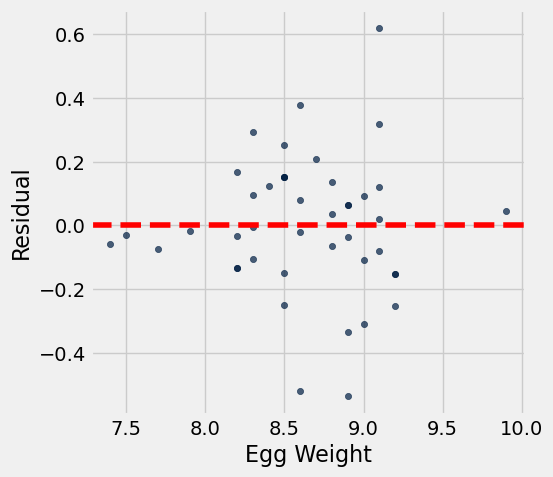

In [14]:
# Generate the residual plot
birds.scatter('Egg Weight', 'Residual')
plt.axhline(y=0, color='r', linestyle='--')  # Horizontal line at y=0
plt.xlabel('Egg Weight')
plt.ylabel('Residual')
plt.show()


<!-- END QUESTION -->

## Finding the Bootstrap Confidence Interval for the True Slope

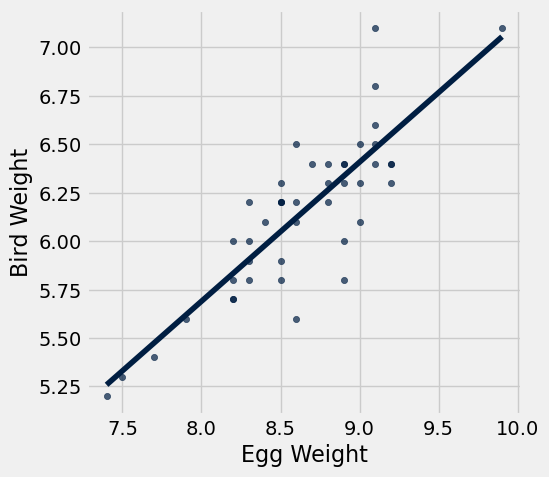

In [15]:
# Just run this cell
birds.scatter('Egg Weight', "Bird Weight", fit_line=True)

Looking at the scatter plot of our sample, we observe a linear relationship between egg weight and bird weight. However, relationships that appear in a sample might not exist in the population from which the sample was taken.

We want to know if there truly exists a linear relationship between egg weight and bird weight for Snowy Plovers. If there is no linear relationship between the two variables, then we'd expect a correlation of 0. Consequently, the slope of the regression line would also be 0. 

We highly recommend reviewing section [16.2](https://inferentialthinking.com/chapters/16/2/Inference_for_the_True_Slope.html) before attempting this part of the homework

#### Task 04 📍🔎

<!-- BEGIN QUESTION -->

Let's run a hypothesis test using confidence intervals to see if there is a linear relationship between egg weight and bird weight. Define the null and alternative hypotheses that will allow you to conduct this test.

*Note:* Please write your answer **in the cell below** in the following format:
- **Null Hypothesis:**
- **Alternative Hypothesis:**

_Points:_ 2

- **Null Hypothesis:** The true slope of the linear relationship between egg weight and bird weight is zero (there is no linear relationship).
- **Alternative Hypothesis:** Alternative Hypothesis: The true slope of the linear relationship between egg weight and bird weight is not zero (there is a linear relationship).


<!-- END QUESTION -->

Next, you will create a confidence interval that quantifies our uncertainty about the true relationship between egg weight and bird weight.

#### Task 05 📍🔎

<!-- BEGIN QUESTION -->

Create an array called `resampled_slopes` that contains the slope of the best fit line for 1,000 bootstrap resamples of `birds`. Plot the distribution of these slopes.

_Points:_ 2

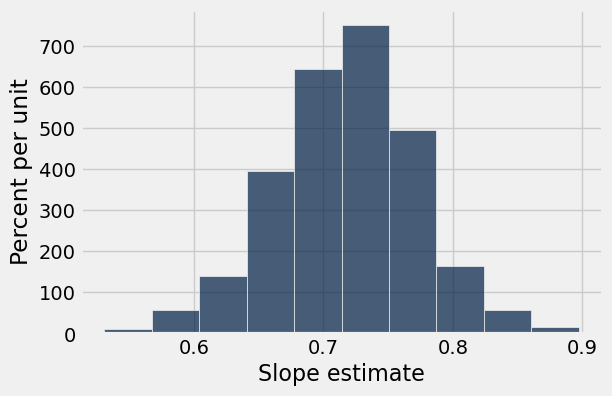

In [16]:
resampled_slopes = make_array()

for i in np.arange(1000):
    birds_bootstrap = birds.sample(with_replacement=True)
    bootstrap_line = np.polyfit(birds_bootstrap.column('Egg Weight'), birds_bootstrap.column('Bird Weight'), 1)
    bootstrap_slope = bootstrap_line[0]
    resampled_slopes = np.append(resampled_slopes, bootstrap_slope)

# DO NOT CHANGE THIS LINE
Table().with_column("Slope estimate", resampled_slopes).hist()


<!-- END QUESTION -->

#### Task 06 📍

Use your resampled slopes to construct an 95% confidence interval for the true value of the slope.

_Points:_ 3

In [17]:
lower_end = np.percentile(resampled_slopes, 2.5)
upper_end = np.percentile(resampled_slopes, 97.5)
print("95% confidence interval for slope: [{:g}, {:g}]".format(lower_end, upper_end))


95% confidence interval for slope: [0.60557, 0.827821]


In [18]:
grader.check("task_06")

task_06 results: All test cases passed!
task_06 - 1 message: ✅ The lower_end value is greater than 0.
task_06 - 2 message: ✅ The upper_end value is less than 4.

#### Task 07 📍🔎

<!-- BEGIN QUESTION -->

In your response, make to address the following:
1. Based on your confidence interval, would you **reject** or **fail to reject** the null hypothesis that the true slope is 0? 
2. Provide an explanation Why?  
3. What p-value cutoff are you using?

**Hint:** Re-read the first section of this homework!

_Points:_ 2

The 95% confidence interval for the slope does not include 0, indicating that we reject the null hypothesis of a zero slope. With a 0.05 p-value cutoff, this suggests strong evidence for a non-zero linear relationship between egg weight and bird weight.

<!-- END QUESTION -->

## Finding the Bootstrap Prediction Interval

Suppose we're visiting Point Reyes and stumble upon some Snowy Plover eggs; we'd like to know how heavy they'll be once they hatch. In other words, we want to use our regression line to make predictions about a bird's weight based on the weight of the corresponding egg.

However, just as we're uncertain about the slope of the true regression line, we're also uncertain about the predictions made based on the true regression line.

#### Task 08 📍

Define the function `fitted_value`.  It should take in four arguments:

1. `table`: a table like `birds`.  We'll be predicting the values in the second column using the first.
2. `x_col`: the name of our x-column within the input `table`
3. `y_col`: the name of our y-column within the input `table`
2. `given_x`: a number, the value of the predictor variable for which we'd like to make a prediction.
  
The function should return the line's prediction for the given x.

*Hint:* Make sure to use the `fit_line` function you defined in Task 11.

_Points:_ 2

In [19]:
def fitted_value(table, x_col, y_col, given_x):
    line = fit_line(table, x_col, y_col)
    slope = line[0]
    intercept = line[1]
    
    y_pred = slope * given_x + intercept
    
    return y_pred

# Here's an example of how fitted_value is used. The code below
# computes the prediction for the bird weight, in grams, based on
# an egg weight of 8 grams.
egg_weight_eight = fitted_value(birds, "Egg Weight", "Bird Weight", 8)
egg_weight_eight

5.6898504972151462

In [20]:
grader.check("task_08")

task_08 results: All test cases passed!
task_08 - 1 message: ✅

#### Task 09 📍

Raymond, the resident Snowy Plover expert at Point Reyes, tells us that the egg he has been carefully observing has a weight of 9 grams. Using `fitted_value` above, assign the variable `experts_egg` to the predicted bird weight for Raymond's egg.

_Points:_ 2

In [21]:
experts_egg = fitted_value(birds, "Egg Weight", "Bird Weight", 9)
experts_egg

6.4083658421088252

In [22]:
grader.check("task_09")

task_09 results: All test cases passed!
task_09 - 1 message: ✅

Let's look at the number of rows in the birds table.

In [38]:
birds.num_rows

44

A fellow parkgoer raises the following objection to your prediction:

> "Your prediction depends on your sample of 44 birds.  Wouldn't your prediction change if you had a different sample of 44 birds?"

Having read section [16.3](https://inferentialthinking.com/chapters/16/3/Prediction_Intervals.html) of the textbook, you know just the response! Had the sample been different, the regression line would have been different too. This would ultimately result in a different prediction. To see how good our prediction is, we must get a sense of how variable the prediction can be.

#### Task 10 📍

Define a function `compute_resampled_line` that takes in a table `tbl`and two column names, `x_col` and `y_col`, and returns an array containing the parameters of the best fit line (slope and intercept) for one bootstrapped resample of the table.

_Points:_ 2

In [23]:
def compute_resampled_line(tbl, x_col, y_col):
    resample = tbl.sample(with_replacement=True)
    resampled_line = np.polyfit(resample.column(x_col), resample.column(y_col), 1)
    return resampled_line

In [24]:
grader.check("task_10")

task_10 results: All test cases passed!
task_10 - 1 message: ✅ Your function returns an array with 2 items.

**Run** the following cell below in order to define the function `bootstrap_lines`.  It takes in four arguments:
1. `tbl`: a table like `birds`
2. `x_col`: the name of our x-column within the input `tbl`
3. `y_col`: the name of our y-column within the input `tbl`
4. `num_bootstraps`: an integer, a number of bootstraps to run.

It returns a *table* with one row for each bootstrap resample and the following two columns:
1. `Slope`: the bootstrapped slopes 
2. `Intercept`: the corresponding bootstrapped intercepts 

In [25]:
# Just run this cell
def bootstrap_lines(tbl, x_col, y_col, num_bootstraps):
    resampled_slopes = make_array()
    resampled_intercepts = make_array() 
    for i in np.arange(num_bootstraps): 
        resampled_line = compute_resampled_line(tbl, x_col, y_col) 
        resampled_slope = resampled_line.item(0) 
        resampled_intercept = resampled_line.item(1) 
        resampled_slopes = np.append(resampled_slopes,resampled_slope)
        resampled_intercepts = np.append(resampled_intercepts,resampled_intercept)
    tbl_lines = Table().with_columns('Slope', resampled_slopes, 'Intercept', resampled_intercepts)
    return tbl_lines

regression_lines = bootstrap_lines(birds, "Egg Weight", "Bird Weight", 1000)
regression_lines

Slope,Intercept
0.699208,0.125433
0.708242,0.0160354
0.6813,0.235676
0.696444,0.0896444
0.686969,0.177459
0.75929,-0.353335
0.739394,-0.263827
0.669117,0.335079
0.709834,-0.00318306
0.742522,-0.235379


#### Task 11 📍🔎

<!-- BEGIN QUESTION -->

Create an array called `predictions_for_eight` that contains the predicted bird weights based on an egg of weight 8 grams for each regression line in `regression_lines`.

_Points:_ 2

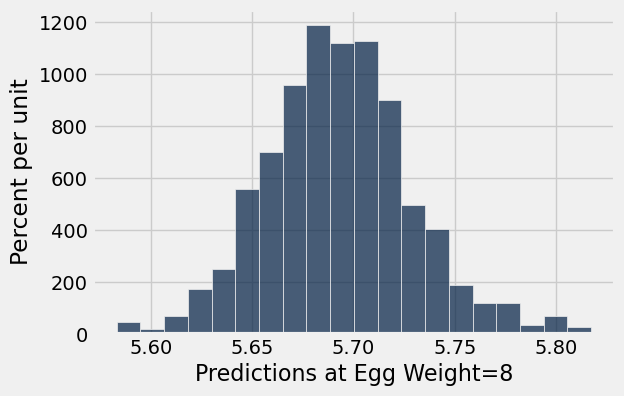

In [26]:
slopes = regression_lines.column('Slope')
intercepts = regression_lines.column('Intercept')

predictions_for_eight = slopes * 8 + intercepts

# This will make a histogram of your predictions:
table_of_predictions = Table().with_column('Predictions at Egg Weight=8', predictions_for_eight)
table_of_predictions.hist('Predictions at Egg Weight=8', bins=20)


<!-- END QUESTION -->

#### Task 12 📍

Create an approximate 95% confidence interval for the predictions in `predictions_for_eight`.

_Points:_ 3

In [27]:
lower_bound = np.percentile(predictions_for_eight, 2.5)
upper_bound = np.percentile(predictions_for_eight, 97.5)

print('95% Confidence interval for predictions for x=8: (', lower_bound,",", upper_bound, ')')


95% Confidence interval for predictions for x=8: ( 5.62498328669 , 5.77389073233 )


In [28]:
grader.check("task_12")

task_12 results: All test cases passed!
task_12 - 1 message: ✅ The lower_bound value is greater than 5.
task_12 - 2 message: ✅ The upper_bound value is less than 6.5.

#### Task 13 📍

Set `plover_statements` to an array of integer(s) that correspond to statement(s) that are true.

1. The 95% confidence interval covers 95% of the bird weights for eggs that had a weight of eight grams in the population of snowy plovers.

2. The 95% confidence interval quantifies the uncertainty in our estimate of what the true line would predict.

_Points:_ 2

In [29]:
plover_statements = make_array(2)

In [30]:
grader.check("task_13")

task_13 results: All test cases passed!
task_13 - 1 message: ✅ plover_statements is an array.

## Submit your Homework to Canvas

Once you have finished working on the homework tasks, prepare to submit your work in Canvas by completing the following steps.

1. In the related Canvas Assignment page, check the rubric to know how you will be scored for this assignment.
2. Double-check that you have run the code cell near the end of the notebook that contains the command `"grader.check_all()"`. This command will run all of the run tests on all your responses to the auto-graded tasks marked with 📍.
3. Double-check your responses to the manually graded tasks marked with 📍🔎.
3. Select the menu item "File" and "Save Notebook" in the notebook's Toolbar to save your work and create a specific checkpoint in the notebook's work history.
4. Select the menu items "File", "Download" in the notebook's Toolbar to download the notebook (.ipynb) file. 
5. In the related Canvas Assignment page, click Start Assignment or New Attempt to upload the downloaded .ipynb file.

**Keep in mind that the auto-grader does not always check for correctness. Sometimes it just checks for the format of your answer, so passing the auto-grader for a task does not mean you got the answer correct for that task.**

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [31]:
grader.check_all()

task_01 results: All test cases passed!
task_01 - 1 message: ✅ Your fit_line function produces an array.
task_01 - 2 message: ✅ The array from your fit_line function contains 2 items.
task_01 - 3 message: ✅ Your fit_line function produced the correct two values for our test data.

task_02 results: All test cases passed!
task_02 - 1 message: ✅ The birds table has the correct labels.
task_02 - 2 message: ✅ The sum of your predicted bird weights seems correct.
task_02 - 3 message: ✅ The average residual calculated from your array residuals is (approximately) 0.
task_02 - 4 message: ✅ The correlation between the egg weights and residuals calculated from your birds table is (approximately) 0.

task_06 results: All test cases passed!
task_06 - 1 message: ✅ The lower_end value is greater than 0.
task_06 - 2 message: ✅ The upper_end value is less than 4.

task_08 results: All test cases passed!
task_08 - 1 message: ✅ 

task_09 results: All test cases passed!
task_09 - 1 message: ✅ 

task_10 re